In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
#import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf
import os.path




from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc

# Assuming your data is organized as NumPy arrays
# gene_observation_matrix is genesXobservations
# gene_category_matrix is genesXcategories
# Both matrices are NumPy arrays

# Example gene_observation_matrix (5 genes, 3 observations) with NaN values


# Calculate the mean of genes for each category and observation, ignoring NaN values
def calculate_category_means_ignore_nan(gene_observation_matrix_df, gene_category_matrix_df):
    # Calculate mean for each category (axis=0) and each observation (axis=1), ignoring NaN values


    genes_intersect = gene_observation_matrix_df.index.intersection(gene_category_matrix_df.index)

    gene_observation_matrix_df =  gene_observation_matrix_df.loc[genes_intersect, :]
    gene_category_matrix_df = gene_category_matrix_df.loc[genes_intersect, :]

    gene_observation_matrix = gene_observation_matrix_df.values
    gene_category_matrix = gene_category_matrix_df.values

    category_counts = np.dot(gene_category_matrix.T, ~np.isnan(gene_observation_matrix))
    
    gene_observation_matrix_cleaned = np.nan_to_num(gene_observation_matrix, nan=0.0)
    
    category_sums = np.dot(gene_category_matrix.T, gene_observation_matrix_cleaned)
    
    # Calculate mean using only non-NaN values
    category_means = category_sums / category_counts
    
    # Replace NaN values in category_means with 0 where division by 0 occurred
    #category_means[np.isnan(category_means)] = 0.0
    
    return category_means, category_counts

# Call the function to calculate category means, ignoring NaN values


def calc_marker_matrix(marker_list,gene_list, no_of_markers=10,  drop_duplicates=True, shuffle_labels=False):
    
        
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]

        marker_list = marker_list.sort_values(by=['rank']).drop_duplicates(subset=['cell_type', 'gene'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()

        marker_list_list = []
        for group2 in all_cell_types:
                    m_tmp = marker_list[marker_list['cell_type']==group2].sort_values(by=['rank'])
                    m_tmp['rank_missing_gene'] = [x+1 for x in range(m_tmp.shape[0])]

                    marker_list_list.append(m_tmp)

        marker_list = pd.concat(marker_list_list)

        marker_list = marker_list[marker_list['rank_missing_gene']<=no_of_markers]

        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        marker_list['%recurrence'] = 1/marker_list['%recurrence']
        
        marker_list_copy = marker_list.copy()
        

        


        if drop_duplicates==True:

            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc', 'rank_missing_gene']).drop_duplicates(subset=['Ensembl_gene_identifier'], keep=False)
        elif drop_duplicates=="one_copy":
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc', 'rank_missing_gene']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        else:
            pass
        
        if shuffle_labels == True:
            

            shuffled_Ensembl_gene_identifier = marker_list['Ensembl_gene_identifier'].sample(frac=1, replace=False, random_state=42).reset_index(drop=True)


            marker_list['Ensembl_gene_identifier'] = shuffled_Ensembl_gene_identifier.tolist()
            
        else:
            pass


        df2_list = []
        for group2 in all_cell_types:
                    
                    m_tmp = marker_list[marker_list['cell_type']==group2]
                    #if number_of_times == 1:
                    df2_list.append(m_tmp)
                    #else:
                    #    random_indices = np.random.choice(m_tmp.index, size=bootstarp_size, replace=True)
                    #    bootstrap_sample = m_tmp.loc[random_indices]
                    #    df2_list.append(bootstrap_sample)

        marker_list=pd.concat(df2_list)
        marker_list_copy['rank'] = 0
        marker_list = pd.concat([marker_list, marker_list_copy])
        
        

        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        

        return marker_table
        

#for each marker-list and input file , I can make one output file

def calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name):
    
        if marker_name == 'GABAergic':
            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_brain_class.csv')
            marker_list = marker_list[marker_list['group']==marker_name]
            
        if marker_name == 'Glutamatergic':
            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_brain_class.csv')
            marker_list = marker_list[marker_list['group']==marker_name]

        
        cell_type_order = marker_list['cell_type'].drop_duplicates().tolist()



        
        

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        
        np_of_col = adata.X.shape[1]
        np_of_rows = len(cell_type_order)
        
        #adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()
        no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
        for given_layer in layer_names:
            for drop_duplicates in [True, False]:
                    for shuf in [True, False]:
                        
                        for no_of_markers in no_of_markers_list:
                            
                                fname = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            
                                if os.path.isfile(fname):
                                    continue
                                adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
                        
                            
                                

                                gene_list = adata.obs_names.tolist()

                                gene_observation_matrix_dataframe = adata.to_df(layer=given_layer)

                                gene_category_dataframe = calc_marker_matrix(marker_list, gene_list, no_of_markers=no_of_markers,  drop_duplicates=drop_duplicates, shuffle_labels=shuf)

                                gene_category_dataframe = gene_category_dataframe.loc[:,cell_type_order]

                                category_means, category_counts = calculate_category_means_ignore_nan(gene_observation_matrix_dataframe, gene_category_dataframe)

                                l_n = f'mean'

                                adata_l.layers[l_n] = category_means

                                l_n = f'counts'

                                adata_l.layers[l_n] = category_counts
                                
                                #z_scores = stats.zscore(category_means, axis=0, nan_policy='omit')
                                #l_n = f'{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_mean_scaled'
                                #adata_l.layers[l_n] = z_scores
                                
                                #z_scores = stats.zscore(category_counts, axis=0, nan_policy='omit')
                                #l_n = f'{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_counts_scaled'
                                #adata_l.layers[l_n] = z_scores


                                adata_l.obs_names = cell_type_order
                                adata_l.var_names = adata.var_names.tolist()

                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'

                                adata_l.write(outputfile_h5ad, compression="gzip")








In [4]:
def calc_marker_number(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name):
    
        if marker_name == 'GABAergic':
            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_brain_class.csv')
            marker_list = marker_list[marker_list['group']==marker_name]
            
        elif marker_name == 'Glutamatergic':
            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_brain_class.csv')
            marker_list = marker_list[marker_list['group']==marker_name]

        else:
            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_{marker_name}.csv') 
        
        cell_type_order = marker_list['cell_type'].drop_duplicates().tolist()



        
        

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        
        np_of_col = adata.X.shape[1]
        np_of_rows = len(cell_type_order)
        
        #adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()
        no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
        for given_layer in layer_names:
            for drop_duplicates in [True]:
                    for shuf in [False]:
                        
                        for no_of_markers in no_of_markers_list:
                            
                                fname = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_true_no_of_markers.h5ad'
                            
                                if os.path.isfile(fname):
                                    continue
                                adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
                        
                                gene_list = adata.obs_names.tolist()

                                gene_observation_matrix_dataframe = adata.to_df(layer=given_layer)

                                gene_category_dataframe = calc_marker_matrix(marker_list, gene_list, no_of_markers=no_of_markers,  drop_duplicates=drop_duplicates, shuffle_labels=shuf)

                                gene_category_dataframe = gene_category_dataframe.loc[:,cell_type_order]

                                gene_category_dataframe.to_csv(fname)




In [6]:
for process_type in ['inter']:
    for resolution in ['10kbp_raw']:
        for dist in [0]:
            for species in ['mouse', 'human']:
                for marker_name in ['Glutamatergic']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_marker_number(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



In [7]:
for process_type in ['inter']:
    for resolution in ['10kbp_raw']:
        for dist in [0]:
            for species in ['human']:
                for marker_name in ['brain_heart']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_marker_number(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)


/home/lohia/miniconda3/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
for process_type in ['inter']:
    for resolution in ['10kbp_raw']:
        for dist in [0]:
            for species in ['mouse']:
                for marker_name in ['brain_blood']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_marker_number(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)


In [3]:
for process_type in ['inter']:
    for resolution in ['10kbp_raw']:
        for dist in [0]:
            for species in ['mouse', 'human']:
                for marker_name in ['GABAergic', 'Glutamatergic']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-e2564f67ff71>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

In [19]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    df_corr = pd.concat([df_b_z, df_z])

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    #features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    #df_dist_df = features_sc.T.corr(min_periods=200, method=corr_method)
    df_dist_df = df_corr.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc


        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad_a, input_file_h5ad_b, file_b_species, outputfile_h5ad, resolution, base_folder, SRP_name):

        adata = ad.read_h5ad(f'{input_file_h5ad_a}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_h5ad_b}', backed='r')
        df_b = adata_b.to_df()

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)




        species_input='mouse'
        species_output='human'
        
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            #os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")

            #os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed -a {full_target_path}/regions_bed_file.tsv > {full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed")

            if species_output=='human':

                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'human_bin', 'a1', 'b1', 'c1', 'mouse_bin', 'overlap'])
            else:
                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'mouse_bin', 'a1', 'b1', 'c1', 'human_bin', 'overlap'])

        #correct bin_id to correct bin_id

        df_human_mouse_bins['mouse_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['mouse_bin'].tolist()]
        df_human_mouse_bins['human_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['human_bin'].tolist()]


        dk_human = df.copy()
        dk_mouse = df_b.copy()

        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['mouse_bin'].isin(dk_mouse.T.index.tolist())]
        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['human_bin'].isin(dk_human.T.index.tolist())]
                

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_b = adata_b.to_df(layer=given_layer)

                                df_b = df_b.loc[cell_type_intersect,:]


                                df = df.loc[:,df_human_mouse_bins['human_bin'].tolist()]

                                df = df.T
                                df.index = df_human_mouse_bins['mouse_bin'].tolist()
                                df = df.T
                                df_b = df_b.loc[:,df_human_mouse_bins['mouse_bin'].tolist()]




                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")





In [24]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
#no_of_markers_list = [200]   
for no_of_markers in no_of_markers_list:

    for species in ['human']:
        for process_type in ['inter', 'intra']:
            for resolution in ['100kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'

                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_cross_species.h5ad'

                                if species == 'human':
                                    species_b = 'mouse'
                                input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, marker_name)
                                calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)


<ipython-input-19-eeeacb4c2716>:105: RuntimeWarning: invalid value encountered in true_divide
  auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse', 'human']:
        for process_type in ['intra']:
            for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw', '250kbp_raw', '1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [0, 1, 10, 100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                #    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





In [8]:
df = pd.read_hdf('/grid/gillis/data_norepl/lohia/hi_c_data_processing/large_dataframe.h5', key='df')

In [81]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.5)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy

In [40]:
pair_groups = ['brain', 'blood', 'heart']
marker_list='brain_class'
layer_2='intra'
species='mouse'
drop_duplicates=False
pair_groups = ['N', 'NN']

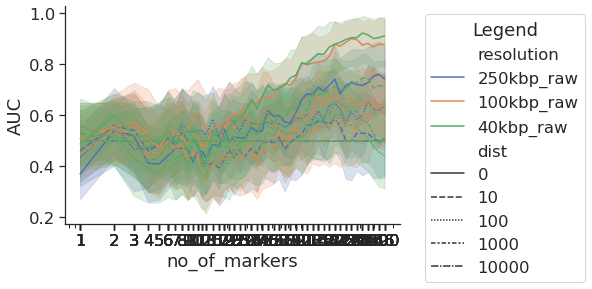

In [43]:
        df_plot = df[df['analysis']=='corr']
        df_plot = df_plot[df_plot['marker_list']==marker_list]
        #df_plot = df_plot[df_plot['resolution']=='100kbp_raw']
        df_plot = df_plot[df_plot['species']==species]
        df_plot =  df_plot[df_plot['shuf'] == False]
        df_plot =  df_plot[df_plot['input_norm_type'] == 'gw_none']
        df_plot =  df_plot[df_plot['drop_duplicates'] == drop_duplicates]
        df_plot =  df_plot[df_plot['given_layer'] == 'z_scores']
        df_plot =  df_plot[df_plot['corr_method'] == 'spearman']
        df_plot =  df_plot[df_plot['inp_norm'].isin(['mean_scaled'])]
        #df_plot =  df_plot[df_plot['dist'] == 0]
        df_plot = df_plot.fillna(0.5)
        df_plot =  df_plot[df_plot['layer_2'] == layer_2]
        #df_plot['no_of_markers_log'] = [np.log(x) for x in  df_plot['no_of_markers']]
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        sns.lineplot(data=df_plot.reset_index(), x=df_plot.reset_index()['no_of_markers'], y='AUC', style='dist', hue='resolution')
        plt.xscale('log')
        
        #sns.lineplot(data=df_plot.reset_index(), x=np.log(df_plot.reset_index()['no_of_markers']), y='AUC', hue='resolution')
        #plt.xlabel(column)
        plt.ylabel('AUC')
        plt.xticks(df_plot.reset_index()['no_of_markers'][::50], labels=[str(x) for x in df_plot.reset_index()['no_of_markers'][::50]])
        plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        

In [5]:
accepted_layer_list = []
for input_norm_type in ['gw_none', 'inter_KR', 'intra_KR', 'intra_KR_obs_exp']:
        if input_norm_type == 'intra_KR_obs_exp':
            layer_1 = ['intra']
            layer_2 = ['intra', 'intra','intra', 'intra', 'intra']
            dist_list = [0]
        elif input_norm_type == 'intra_KR':
            layer_1 = ['intra']
            layer_2 = ['intra', 'intra','intra', 'intra', 'intra']
            dist_list = [0]
        elif input_norm_type == 'gw_none':
            layer_1 = ['gw']
            layer_2 = ['intra','inter']
            dist_list = [0, 0]
        else:
            layer_1 = ['inter']
            layer_2 = ['inter']
            dist_list = [0]
            
        for process_type in layer_1:
            for layer_type, dist in zip(layer_2, dist_list) :

                    no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,26,29,33,37,41,46,52,58,65,73,82,92,103,115,129,144,162,181,202,227,254,284,318,356,399,446,500]
                    for no_of_markers in no_of_markers_list:
                        for drop_duplicates in [True,False]:
                            for shuf in [False]:
                                for given_layer in ['z_scores']:
                                    for inp_norm in ['mean_scaled']:
                                    #for inp_norm in ['mean', 'counts', 'mean_scaled']:
                                            if given_layer == 'none':
                                                l_n = f'{process_type}_{layer_type}_{dist}_{no_of_markers}_{drop_duplicates}_{shuf}_{inp_norm}'
                                            else:
                                                
                                                l_n = f'{process_type}_{layer_type}_{dist}_{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_{inp_norm}'
                                            accepted_layer_list.append(l_n)


In [120]:
#df_list = []
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['human']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            #calc_egad_vals(input_file_h5ad, outputfile_h5ad)
                            adata = ad.read_h5ad(f'{outputfile_h5ad}', backed='r')
                            df_layer = adata.uns['mean_pearson'].reset_index()

                            df_layer['no_of_markers'] = no_of_markers
                            df_layer['drop_duplicates'] = drop_duplicates
                            df_layer['shuf'] = shuf
                            df_layer['dist'] = dist

                            df_layer['resolution'] = resolution
                            df_layer['marker_list'] = marker_name
                            df_layer['species'] = species
                            df_layer['process_type'] = process_type
                            df_list.append(df_layer)


In [91]:
df_list_atac = []
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                            #calc_egad_vals(input_file_h5ad, outputfile_h5ad)
                            adata = ad.read_h5ad(f'{outputfile_h5ad}', backed='r')
                            df_layer = adata.uns['mean_pearson'].reset_index()

                            df_layer['no_of_markers'] = no_of_markers
                            df_layer['drop_duplicates'] = drop_duplicates
                            df_layer['shuf'] = shuf
                            df_layer['dist'] = dist

                            df_layer['resolution'] = resolution
                            df_layer['marker_list'] = marker_name
                            df_layer['species'] = species
                            df_layer['process_type'] = process_type
                            df_list_atac.append(df_layer)


In [137]:
outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'



In [138]:
adata = ad.read_h5ad(f'{outputfile_h5ad}', backed='r')

In [143]:
adata.to_df(layer='mean')

bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  \
Chandelier    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Lamp5_Lhx6    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
OPC           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Lamp5         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Pax6          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Sncg          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L4 IT         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L5 IT         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Pvalb         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L2/3 IT       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L6 IT         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L6 IT Car3    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L6b           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Astro         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Micro-PVM     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Oligo         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
VLMC          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Sst Chodl     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Vip           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L6 CT         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L5 ET         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Sst           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
L5/6 NP       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Endo          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

            bin_9  ...  bin_287499  bin_287500  bin_287501  bin_287502  \
Chandelier    NaN  ...    0.380221   -0.044378    0.051627   -0.288211   
Lamp5_Lhx6    NaN  ...    0.099319   -0.136691   -0.166193   -0.273286   
OPC           NaN  ...    0.262669    0.280833    0.036138   -0.307286   
Lamp5         NaN  ...   -0.084437    0.025394   -0.145844   -0.241038   
Pax6          NaN  ...    0.114043    0.048690   -0.088389   -0.266591   
Sncg          NaN  ...   -0.105051   -0.079974    0.058057   -0.301947   
L4 IT         NaN  ...    0.038069   -0.059683   -0.078343   -0.290120   
L5 IT         NaN  ...    0.313753    0.231731   -0.158110   -0.322122   
Pvalb         NaN  ...    0.054189    0.016340    0.083735   -0.278213   
L2/3 IT       NaN  ...   -0.003151    0.231472    0.166569   -0.268217   
L6 IT         NaN  ...   -0.021244   -0.006095    0.309180   -0.108554   
L6 IT Car3    NaN  ...    0.133748    0.073090    0.037983   -0.278178   
L6b           NaN  ...   -0.084080   -0.177424   -0.031389   -0.306013   
Astro         NaN  ...    0.286235    0.121781    0.126334   -0.177969   
Micro-PVM     NaN  ...    0.203343    0.032837    0.047690   -0.264831   
Oligo         NaN  ...    0.370726    0.058206   -0.025733   -0.266960   
VLMC          NaN  ...    0.189971    0.258327    0.464852   -0.195315   
Sst Chodl     NaN  ...   -0.005437   -0.094686   -0.028577   -0.296945   
Vip           NaN  ...    0.173301    0.224063   -0.144532   -0.315256   
L6 CT         NaN  ...    0.062739   -0.235437    0.078721   -0.235437   
L5 ET         NaN  ...    0.141574    0.386260   -0.077081   -0.136259   
Sst           NaN  ...    0.067988    0.169305    0.154654   -0.288051   
L5/6 NP       NaN  ...   -0.052171    0.053310   -0.124041   -0.267258   
Endo          NaN  ...    0.276098    0.019195    0.168338   -0.276228   

            bin_287503  bin_287504  bin_287505  bin_287506  bin_287507  \
Chandelier    0.192218    0.133184         NaN         NaN         NaN   
Lamp5_Lhx6   -0.036597    0.045751         NaN         NaN         NaN   
OPC          

In [121]:
df = pd.concat(df_list)

In [127]:
df[df['marker_list']==marker_list]

index       AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value  no_of_markers  \
0      N  0.642063         3.421855         0.486607  0.035919              1   
1     NN  0.552083         3.520553         0.513393  0.227921              1   
0      N  0.532540         3.435786         0.741071  0.119118              1   
1     NN  0.399306         3.488711         0.258929  0.153552              1   
0      N  0.500000         3.408225         0.357143  0.124825              1   
..   ...       ...              ...              ...       ...            ...   
1     NN  0.407407        44.096663         0.611111  0.191367            500   
0      N  0.888889        28.146740         0.018519  0.000052            500   
1     NN  0.981481        30.064883         0.981481  0.000078            500   
0      N  0.842593        37.758915         0.981481  0.000312            500   
1     NN  0.842593        36.472543         0.018519  0.003558            500   

    drop_duplicates   shuf  dist  resolution  marker_list species process_type  
0              True   True     0  250kbp_raw  brain_class   mouse        intra  
1              True   True     0  250kbp_raw  brain_class   mouse        intra  
0             False   True     0  250kbp_raw  brain_class   mouse        intra  
1             False   True     0  250kbp_raw  brain_class   mouse        intra  
0              True  False     0  250kbp_raw  brain_class   mouse        intra  
..              ...    ...   ...         ...          ...     ...          ...  
1             False   True     0   10kbp_raw  brain_class   human        inter  
0              True  False     0   10kbp_raw  brain_class   human        inter  
1              True  False     0   10kbp_raw  brain_class   human        inter  
0             False  False     0   10kbp_raw  brain_class   human        inter  
1             False  False     0   10kbp_raw  brain_class   human        inter  

[5890 rows x 13 columns]

In [136]:
adata.to_df(layer='mean_pearson')

Chandelier  Lamp5_Lhx6       OPC     Lamp5      Pax6      Sncg  \
Chandelier    1.000000    0.929660  0.912338  0.931210  0.926077  0.918167   
Lamp5_Lhx6    0.929660    1.000000  0.914567  0.962309  0.939285  0.924649   
OPC           0.912338    0.914567  1.000000  0.914405  0.914863  0.916304   
Lamp5         0.931210    0.962309  0.914405  1.000000  0.944778  0.936848   
Pax6          0.926077    0.939285  0.914863  0.944778  1.000000  0.937180   
Sncg          0.918167    0.924649  0.916304  0.936848  0.937180  1.000000   
L4 IT         0.927149    0.927215  0.907824  0.928938  0.924771  0.926321   
L5 IT         0.903723    0.914080  0.918339  0.912367  0.912575  0.921559   
Pvalb         0.938918    0.919965  0.908965  0.919414  0.917527  0.912308   
L2/3 IT       0.928795    0.927184  0.895240  0.927258  0.918871  0.913140   
L6 IT         0.921232    0.928790  0.905091  0.929426  0.920739  0.920064   
L6 IT Car3    0.920260    0.919375  0.872968  0.922157  0.919425  0.903133   
L6b           0.921878    0.926893  0.924349  0.931634  0.929717  0.926596   
Astro         0.859464    0.844950  0.768744  0.849770  0.853161  0.818815   
Micro-PVM     0.790407    0.776182  0.673998  0.778602  0.774284  0.735495   
Oligo         0.829626    0.814544  0.726823  0.820616  0.819303  0.784506   
VLMC          0.874454    0.859435  0.790780  0.863259  0.864907  0.834244   
Sst Chodl     0.924357    0.917177  0.885801  0.919928  0.917716  0.903528   
Vip           0.928426    0.920713  0.904239  0.926835  0.932176  0.932412   
L6 CT         0.924888    0.927328  0.919810  0.928893  0.929414  0.922609   
L5 ET         0.920643    0.912968  0.880746  0.916850  0.913409  0.898417   
Sst           0.917581    0.920821  0.930595  0.918466  0.919373  0.921435   
L5/6 NP       0.924469    0.920630  0.901241  0.926423  0.924977  0.913266   
Endo          0.794218    0.776569  0.677944  0.781846  0.779159  0.740647   

               L4 IT     L5 IT     Pvalb   L2/3 IT  ...  Micro-PVM     Oligo  \
Chandelier  0.927149  0.903723  0.938918  0.928795  ...   0.790407  0.829626   
Lamp5_Lhx6  0.927215  0.914080  0.919965  0.927184  ...   0.776182  0.814544   
OPC         0.907824  0.918339  0.908965  0.895240  ...   0.673998  0.726823   
Lamp5       0.928938  0.912367  0.919414  0.927258  ...   0.778602  0.820616   
Pax6        0.924771  0.912575  0.917527  0.918871  ...   0.774284  0.819303   
Sncg        0.926321  0.921559  0.912308  0.913140  ...   0.735495  0.784506   
L4 IT       1.000000  0.917215  0.932341  0.915113  ...   0.771847  0.811591   
L5 IT       0.917215  1.000000  0.916062  0.875442  ...   0.670716  0.722468   
Pvalb       0.932341  0.916062  1.000000  0.926431  ...   0.791036  0.828003   
L2/3 IT     0.915113  0.875442  0.926431  1.000000  ...   0.826861  0.860878   
L6 IT       0.917393  0.909208  0.929598  0.924524  ...   0.785106  0.824228   
L6 IT Car3  0.915571  0.870079  0.922680  0.927552  ...   0.852659  0.885099   
L6b         0.919748  0.924348  0.926479  0.910702  ...   0.746713  0.793107   
Astro       0.838559  0.758158  0.854646  0.885650  ...   0.922672  0.935877   
Micro-PVM   0.771847  0.670716  0.791036  0.826861  ...   1.000000  0.938305   
Oligo       0.811591  0.722468  0.828003  0.860878  ...   0.938305  1.000000   
VLMC        0.857308  0.784556  0.869992  0.896634  ...   0.921684  0.932969   
Sst Chodl   0.915185  0.880913  0.921347  0.930262  ...   0.840773  0.872103   
Vip         0.921332  0.891785  0.918188  0.928248  ...   0.809109  0.851220   
L6 CT       0.921116  0.922701  0.928184  0.914540  ...   0.767696  0.809358   
L5 ET       0.904154  0.873496  0.923819  0.928465  ...   0.856616  0.884543   
Sst         0.923176  0.932539  0.926323  0.913230  ...   0.720935  0.770542   
L5/6 NP     0.920014  0.897481  0.923529  0.918282  ...   0.808230  0.846166   
Endo        0.773497  0.670379  0.790601  0.832830  ...   0.954228  0.942689   

                VLMC  Sst Chodl       Vip     L6 CT     L5 E

In [128]:
marker_list = 'brain_class'
drop_duplicates=True

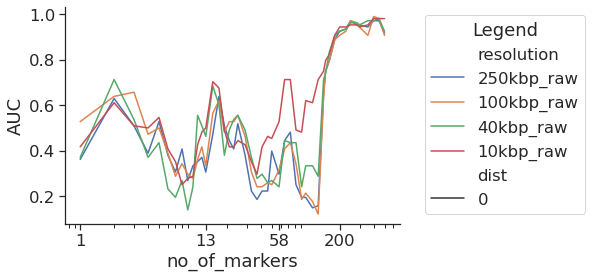

In [131]:

        df_plot = df[df['marker_list']==marker_list]
        #df_plot = df_plot[df_plot['resolution']=='100kbp_raw']
        df_plot = df_plot[df_plot['species']==species]
        df_plot =  df_plot[df_plot['shuf'] == False]
        df_plot =  df_plot[df_plot['index'] == 'NN']
        
        df_plot =  df_plot[df_plot['process_type'] == 'inter']
        df_plot =  df_plot[df_plot['drop_duplicates'] == drop_duplicates]

        #df_plot =  df_plot[df_plot['dist'] == 0]
        df_plot = df_plot.fillna(0.5)

        #df_plot['no_of_markers_log'] = [np.log(x) for x in  df_plot['no_of_markers']]
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        #df_plot = df_plot[df_plot.index.isin(pair_groups)]
        sns.lineplot(data=df_plot.reset_index(), x=df_plot.reset_index()['no_of_markers'], y='AUC', style='dist', hue='resolution')
        plt.xscale('log')
        
        #sns.lineplot(data=df_plot.reset_index(), x=np.log(df_plot.reset_index()['no_of_markers']), y='AUC', hue='resolution')
        #plt.xlabel(column)
        plt.ylabel('AUC')
        plt.xticks(df_plot.reset_index()['no_of_markers'][::50], labels=[str(x) for x in df_plot.reset_index()['no_of_markers'][::50]])
        plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        

In [66]:
    species='human'
    SRP_name='aggregates'
    resolution='1kbp_raw'
    base_folder='/grid/gillis/data_norepl/lohia/'

In [87]:
adata = ad.read_h5ad(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_intra_KR_0_z_scores_False_False_brain_class_10_by_allbins_max_mean_atac.h5ad', backed='r')


In [88]:
adata.layers

Layers with keys: counts_pearson, mean_pearson

In [89]:
adata.uns

{'counts_pearson':     cell_type     AUC
 0       Lamp5  0.2500
 1       Pvalb  0.3750
 2        Sncg  0.1250
 3         Sst  0.8125
 4   Sst Chodl  0.8750
 5         Vip  0.0000
 6     L2/3 IT  0.5000
 7       L5 IT  0.1250
 8     L5/6 NP  0.0625
 9       L6 CT  0.9375
 10      L6 IT  0.7500
 11        L6b  0.7500
 12      Astro  0.5625
 13       Endo  0.1250
 14  Micro-PVM  0.9375
 15      Oligo  1.0000
 16       VLMC  0.8750,
 'mean_pearson':     cell_type     AUC
 0       Lamp5  0.7500
 1       Pvalb  1.0000
 2        Sncg  1.0000
 3         Sst  0.8750
 4   Sst Chodl  0.0000
 5         Vip  0.9375
 6     L2/3 IT  0.7500
 7       L5 IT  0.4375
 8     L5/6 NP  0.6875
 9       L6 CT  1.0000
 10      L6 IT  0.9375
 11        L6b  0.8750
 12      Astro  0.1875
 13       Endo  0.0000
 14  Micro-PVM  0.9375
 15      Oligo  0.8125
 16       VLMC  0.8125}

In [78]:
adata.uns['mean_pearson'].reset_index()

index       AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
0     N  0.620370         1.873511         0.527778  0.114711
1    NN  0.324074         1.831273         0.472222  0.083479

In [51]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    #features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = df_corr.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [ ]:

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'



In [ ]:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'

In [ ]:
        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    

In [ ]:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)


In [56]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:




    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



    for species in ['mouse']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)










<ipython-input-51-2eb4d49e5a2e>:106: RuntimeWarning: invalid value encountered in true_divide
  auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)


In [57]:
    for species in ['human']:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)




    for species in ['human']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



OSError: Unable to create file (unable to truncate a file which is already open)

In [17]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc

def get_atac_values(resolution):
    species='mouse'
    base_folder='/grid/gillis/data_norepl/lohia/'
    SRP_name='aggregates'

    cell_type_map = {'VLMC' : 'VLMC' ,
    'Micro-PVM' : 'MGC' ,
    'Astro' : 'ASC' ,
    'L2/3 IT' : 'L2_3_IT' ,
    'L5 IT' : 'L5_IT' ,
    'Oligo' : 'ODC' ,
    'Sst' : 'SST' ,
    'Pvalb' : 'PVALB' ,
    'Vip' : 'VIP' ,
    'Endo' : 'Endo' ,
    'Lamp5' : 'LAMP5' ,
    'Sncg' : 'SNCG' ,
    'L5/6 NP' : 'L5_6_NP' ,
    'L5 ET' : 'L5_ET' ,
    'L6 CT' : 'L6_CT' ,
    'L6b' :  'L6b' ,
    'Sst Chodl' : 'SST' ,
    'L6 IT' : 'L6_IT' 
    }



    df_marker = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

    df_marker = df_marker.drop_duplicates('group')

    class_dict = dict(zip(df_marker.group, df_marker.classt))

    df_atac_subclass_macs2 = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/Supplementary_Table_7.tsv', sep='\t')



    df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
    df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
    df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
    df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



    df_list = []
    for keyl in cell_type_map.keys():

        df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
        df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
        df['cell_type'] = keyl
        df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
    df_Zemke2023_label = pd.concat(df_list)

    df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()
    b_dir = f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'

    df_Zemke2023_label.to_csv(f'{b_dir}/all_cre_{resolution}.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre_{resolution}.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {b_dir}/all_cre_bins_{resolution}.bed")

    df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins_{resolution}.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

    df_Zemke2023['rank'] = 1






    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]
    #df_Zemke2023 = df_Zemke2023.sort_values( by=['overlap'], ascending=False).drop_duplicates(subset=['bin_id'])

    #df_Zemke2023['cell_type'] = [class_dict[x] if x in class_dict.keys() else 'del' for x in df_Zemke2023['cell_type'].tolist()]

    df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

    df_Zemke2023_table.fillna(0, inplace=True)

    df_Zemke2023_table[df_Zemke2023_table != 0] = 1

    df_Zemke2023_mouse = df_Zemke2023_table.T
    
    print (df_Zemke2023_mouse)

    #df_Zemke2023_mouse = df_Zemke2023_table[~df_Zemke2023_table.index.isin(['del'])]




    adata = ad.AnnData(df_Zemke2023_mouse)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/zemke_brain.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path








    #z_score_human
    species='human'

    cell_type_map = {'VLMC' : 'VLMC' ,
    'Micro-PVM' : 'MGC' ,
    'Astro' : 'ASC' ,
    'L2/3 IT' : 'L2_3_IT' ,
    'L5 IT' : 'L5_IT' ,
    'Oligo' : 'ODC' ,
    'Sst' : 'SST' ,
    'Pvalb' : 'PVALB' ,
    'Vip' : 'VIP' ,
    'Endo' : 'Endo' ,
    'Lamp5' : 'LAMP5' ,
    'Sncg' : 'SNCG' ,
    'L5/6 NP' : 'L5_6_NP' ,
    'L5 ET' : 'L5_ET' ,
    'L6 CT' : 'L6_CT' ,
    'L6b' :  'L6b' ,
    'Sst Chodl' : 'SST' ,
    'L6 IT' : 'L6_IT' 
    }

    df_atac_subclass_macs2 = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/zemke_2023/Supplementary_Table_4.tsv', sep='\t')



    df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
    df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
    df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
    df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



    df_list = []
    for keyl in cell_type_map.keys():

        df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
        df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
        df['cell_type'] = keyl
        df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
    df_Zemke2023_label = pd.concat(df_list)

    df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()




    b_dir = f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/zemke_2023/'

    df_Zemke2023_label.to_csv(f'{b_dir}/all_cre_{resolution}.bed', index=False, header=False, sep='\t')


    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre_{resolution}.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {b_dir}/all_cre_bins_{resolution}.bed")

    df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins_{resolution}.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

    df_Zemke2023['rank'] = 1

    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]


    df_marker = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

    df_marker = df_marker.drop_duplicates('group')

    class_dict = dict(zip(df_marker.group, df_marker.classt))

    df_Zemke2023['group'] = [class_dict[x] if x in class_dict.keys() else 'del' for x in df_Zemke2023['cell_type'].tolist()]


    #df = df[df['subclass'].isin(['Glial & Endo', 'VLMC'])]
    #df = df[df['subclass'].isin(['CGE-derived', 'MGE-derived'])]
    #df = df[df['subclass'].isin(['IT-derived', 'Non-IT-derived'])]
    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['cell_type'].isin(df['cell_type'].tolist())]
    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['group']=='Glutamatergic']

    df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

    df_Zemke2023_table.fillna(0, inplace=True)

    df_Zemke2023_table[df_Zemke2023_table != 0] = 1

    df_Zemke2023_human = df_Zemke2023_table.T
    #df_Zemke2023_human = df_Zemke2023_table[~df_Zemke2023_table.index.isin(['del'])]

    adata = ad.AnnData(df_Zemke2023_human)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/zemke_brain.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path





    df_heart = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/hocker_heart/heart_table_s6.tsv', sep='\t', skiprows=1)
    df_heart.to_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/hocker_heart/heart.bed',header=False, index=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -a {base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/hocker_heart/heart.bed -b {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules_heart.bed")
    df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules_heart.bed', sep='\t', names=['a', 'b','c' ,'logfc', 'p_val', 'cell_type', 'chr', 'start', 'end', 'bin_id', 'overlap'])


    #df_hba_modules = df_hba_modules[df_hba_modules['overlap'] > 250]

    df_hocker_table = df_hba_modules.pivot_table(index='bin_id', columns='cell_type', values='logfc', aggfunc='sum')

    df_hocker_table.fillna(0, inplace=True)

    df_hocker_table[df_hocker_table != 0] = 1

    df_hocker_human = df_hocker_table.T

    adata = ad.AnnData(df_hocker_human)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/zemke_heart.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path


    import pyBigWig



    name_category_dict = {
        'Astro-NT_NN': 'Astro',
        'Lamp5_Gaba': 'Lamp5',
        'Astro-TE_NN': 'Astro',
        'Lamp5_Lhx6_Gaba': 'Lamp5_Lhx6',
        'Endo_NN': 'Endo',
        'Microglia_NN': 'Micro-PVM',
        'L2_3_IT_CTX_Glut': 'L2/3 IT',
        'Oligo_NN': 'Oligo',
        'L4_5_IT_CTX_Glut': 'L4/5 IT',
        'OPC_NN': 'OPC',
        'L4_RSP-ACA_Glut': 'L4 RSP-ACA',
        'Peri_NN': 'Peri',
        'L5_ET_CTX_Glut': 'L5 ET',
        'Pvalb_chandelier_Gaba': 'Chandelier',
        'L5_IT_CTX_Glut': 'L5 IT',
        'Pvalb_Gaba': 'Pvalb',
        'L5_NP_CTX_Glut': 'L5 NP',
        'Sncg_Gaba': 'Sncg',
        'L6b_CTX_Glut': 'L6b',
        'Sst_Gaba': 'Sst',
        'L6_CT_CTX_Glut': 'L6 CT',
        'Vip_Gaba': 'Vip',
        'L6_IT_CTX_Glut': 'L6 IT',
        'VLMC_NN': 'VLMC'
    }

    species='mouse'
    SRP_name='aggregates'


    compartment_list  = []

    for f_name, f_mapped in zip(name_category_dict.keys(), name_category_dict.values()):

        f_path = "/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/liu-2023-sn3c/compartment_score/"

        m_p = f"{f_path}/{f_name}.compartment_score.100K.bw"

        bw_file = pyBigWig.open(m_p)



        bedgraph_file = f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/your_output_file.bedgraph'

        # Open the BedGraph file for writing
        with open(bedgraph_file, 'w') as f:
            for chrom in bw_file.chroms():
                # Iterate over each chromosome in the BigWig file
                intervals = bw_file.intervals(chrom)
                for interval in intervals:
                    # Write each interval to the BedGraph file
                    f.write(f"{chrom}\t{interval[0]}\t{interval[1]}\t{interval[2]}\n")


        # Close the BigWig file
        bw_file.close()

        os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b /grid/gillis/data_norepl/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/your_output_file.bedgraph -a /grid/gillis/data_norepl/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {f_path}/intersect_{resolution}.bed")


        enhancer_bins = pd.read_csv(f'{f_path}/intersect_{resolution}.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'compartment_score', 'overlap'])
        enhancer_bins['cell_type'] = f_mapped
        compartment_list.append(enhancer_bins)



    compartment_matrix = pd.concat(compartment_list)



    compartment_df = compartment_matrix.pivot_table(columns='bin_id', index='cell_type', values='compartment_score', aggfunc='mean')


    adata = ad.AnnData(compartment_df)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/compartment.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path
    
    


    




In [18]:
for resolution in [ '10kbp_raw']:
    get_atac_values(resolution)

<ipython-input-17-4fe53a83664f>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-17-4fe53a83664f>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-17-4fe53a83664f>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Empty DataFrame
Columns: []
Index: []


ValueError: no types given

In [42]:
input_file_another_exp_h5ad = '/grid/gillis/data_norepl/lohia//hi_c_data_processing/data_mouse/aggregates/100kbp_raw/max/zemke_brain.h5ad'



In [43]:
adata = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')

In [37]:
adata.to_df()

bin_30  bin_31  bin_32  bin_33  bin_34  bin_35  bin_36  bin_37  \
cell_type                                                                   
Astro         0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
Endo          0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
L2/3 IT       1.0     1.0     1.0     1.0     1.0     0.0     1.0     0.0   
L5 ET         1.0     1.0     1.0     1.0     1.0     0.0     1.0     0.0   
L5 IT         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
L5/6 NP       0.0     1.0     0.0     1.0     1.0     1.0     1.0     0.0   
L6 CT         1.0     1.0     1.0     1.0     1.0     0.0     1.0     1.0   
L6 IT         1.0     1.0     1.0     1.0     1.0     0.0     1.0     1.0   
L6b           0.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Lamp5         0.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Micro-PVM     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
Oligo         0.0     0.0     1.0     1.0     1.0     1.0     1.0     0.0   
Pvalb         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Sncg          1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0   
Sst           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Sst Chodl     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
VLMC          0.0     1.0     1.0     1.0     0.0     0.0     1.0     0.0   
Vip           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

           bin_38  bin_39  ...  bin_24627  bin_24628  bin_24629  bin_24630  \
cell_type                  ...                                               
Astro         0.0     0.0  ...        1.0        1.0        1.0        0.0   
Endo          0.0     0.0  ...        0.0        0.0        1.0        0.0   
L2/3 IT       0.0     1.0  ...        1.0        1.0        1.0        1.0   
L5 ET         0.0     1.0  ...        1.0        1.0        1.0        1.0   
L5 IT         0.0     1.0  ...        1.0        1.0        1.0        1.0   
L5/6 NP       0.0     0.0  ...        1.0        1.0        1.0        0.0   
L6 CT         1.0     1.0  ...        1.0        1.0        1.0        1.0   
L6 IT         0.0     1.0  ...        1.0        1.0        1.0        1.0   
L6b           0.0     1.0  ...        1.0        1.0        1.0        1.0   
Lamp5         0.0     1.0  ...        0.0        1.0        1.0        1.0   
Micro-PVM     0.0     0.0  ...        0.0        1.0        1.0        1.0   
Oligo         0.0     1.0  ...        1.0        1.0        1.0        0.0   
Pvalb         0.0     0.0  ...        1.0        1.0        1.0        1.0   
Sncg          0.0     1.0  ...        1.0        1.0        1.0        1.0   
Sst           0.0     0.0  ...        1.0        1.0        1.0        1.0   
Sst Chodl     0.0     0.0  ...        1.0        1.0        1.0        1.0   
VLMC          0.0     0.0  ...        0.0        1.0        1.0        0.0   
Vip           0.0     0.0  ...        1.0        1.0        1.0        1.0   

           bin_24631  bin_24632  bin_24633  bin_24634  bin_24635  bin_24636  
cell_type                                                                    
Astro            1.0        1.0        0.0        1.0        1.0        1.0  
Endo             1.0        1.0        1.0        0.0        1.0        1.0  
L2/3 IT          1.0        1.0        1.0        1.0        1.0        1.0  
L5 ET            1.0        1.0        1.0        1.0        1.0        1.0  
L5 IT            1.0        1.0        1.0        1.0        1.0        1.0  
L5/6 NP          1.0        1.0        1.0        1.0        1.0        1.0  
L6 CT            1.0        1.0        1.0        1.0        1.0        1.0  
L6 IT            1.0        1.0        1.0        1.0        1.0        1.0  
L6b              1.0        1.0        1.0        1.0        1.0        1.0  
Lamp5            1.0        1.0        1.0        1

In [19]:
resolution='10kbp_raw'

In [23]:
    species='mouse'
    base_folder='/grid/gillis/data_norepl/lohia/'
    SRP_name='aggregates'

    cell_type_map = {'VLMC' : 'VLMC' ,
    'Micro-PVM' : 'MGC' ,
    'Astro' : 'ASC' ,
    'L2/3 IT' : 'L2_3_IT' ,
    'L5 IT' : 'L5_IT' ,
    'Oligo' : 'ODC' ,
    'Sst' : 'SST' ,
    'Pvalb' : 'PVALB' ,
    'Vip' : 'VIP' ,
    'Endo' : 'Endo' ,
    'Lamp5' : 'LAMP5' ,
    'Sncg' : 'SNCG' ,
    'L5/6 NP' : 'L5_6_NP' ,
    'L5 ET' : 'L5_ET' ,
    'L6 CT' : 'L6_CT' ,
    'L6b' :  'L6b' ,
    'Sst Chodl' : 'SST' ,
    'L6 IT' : 'L6_IT' 
    }



    df_marker = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

    df_marker = df_marker.drop_duplicates('group')

    class_dict = dict(zip(df_marker.group, df_marker.classt))

    df_atac_subclass_macs2 = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/Supplementary_Table_7.tsv', sep='\t')



    df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['coord']]
    df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
    df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
    df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
    df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



    df_list = []
    for keyl in cell_type_map.keys():

        df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
        df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
        df['cell_type'] = keyl
        df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
    df_Zemke2023_label = pd.concat(df_list)

    df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()
    b_dir = f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'

    df_Zemke2023_label.to_csv(f'{b_dir}/all_cre_{resolution}.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre_{resolution}.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {b_dir}/all_cre_bins_{resolution}.bed")

    df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins_{resolution}.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

    df_Zemke2023['rank'] = 1
    
    print (df_Zemke2023)






    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]
    #df_Zemke2023 = df_Zemke2023.sort_values( by=['overlap'], ascending=False).drop_duplicates(subset=['bin_id'])

    #df_Zemke2023['cell_type'] = [class_dict[x] if x in class_dict.keys() else 'del' for x in df_Zemke2023['cell_type'].tolist()]

    df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

    df_Zemke2023_table.fillna(0, inplace=True)

    df_Zemke2023_table[df_Zemke2023_table != 0] = 1

    df_Zemke2023_mouse = df_Zemke2023_table.T
    
    print (df_Zemke2023_mouse)

    #df_Zemke2023_mouse = df_Zemke2023_table[~df_Zemke2023_table.index.isin(['del'])]




    adata = ad.AnnData(df_Zemke2023_mouse)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/zemke_brain.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path








    #z_score_human
    species='human'

    cell_type_map = {'VLMC' : 'VLMC' ,
    'Micro-PVM' : 'MGC' ,
    'Astro' : 'ASC' ,
    'L2/3 IT' : 'L2_3_IT' ,
    'L5 IT' : 'L5_IT' ,
    'Oligo' : 'ODC' ,
    'Sst' : 'SST' ,
    'Pvalb' : 'PVALB' ,
    'Vip' : 'VIP' ,
    'Endo' : 'Endo' ,
    'Lamp5' : 'LAMP5' ,
    'Sncg' : 'SNCG' ,
    'L5/6 NP' : 'L5_6_NP' ,
    'L5 ET' : 'L5_ET' ,
    'L6 CT' : 'L6_CT' ,
    'L6b' :  'L6b' ,
    'Sst Chodl' : 'SST' ,
    'L6 IT' : 'L6_IT' 
    }

    df_atac_subclass_macs2 = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/zemke_2023/Supplementary_Table_4.tsv', sep='\t')



    df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['hg38_coord']]
    df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
    df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
    df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
    df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



    df_list = []
    for keyl in cell_type_map.keys():

        df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
        df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
        df['cell_type'] = keyl
        df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
    df_Zemke2023_label = pd.concat(df_list)

    df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()




    b_dir = f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/human/zemke_2023/'

    df_Zemke2023_label.to_csv(f'{b_dir}/all_cre_{resolution}.bed', index=False, header=False, sep='\t')


    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre_{resolution}.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {b_dir}/all_cre_bins_{resolution}.bed")

    df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins_{resolution}.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

    df_Zemke2023['rank'] = 1

    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]


    df_marker = pd.read_csv(f'{base_folder}/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

    df_marker = df_marker.drop_duplicates('group')

    class_dict = dict(zip(df_marker.group, df_marker.classt))

    df_Zemke2023['group'] = [class_dict[x] if x in class_dict.keys() else 'del' for x in df_Zemke2023['cell_type'].tolist()]


    #df = df[df['subclass'].isin(['Glial & Endo', 'VLMC'])]
    #df = df[df['subclass'].isin(['CGE-derived', 'MGE-derived'])]
    #df = df[df['subclass'].isin(['IT-derived', 'Non-IT-derived'])]
    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['cell_type'].isin(df['cell_type'].tolist())]
    #df_Zemke2023 = df_Zemke2023[df_Zemke2023['group']=='Glutamatergic']

    df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

    df_Zemke2023_table.fillna(0, inplace=True)

    df_Zemke2023_table[df_Zemke2023_table != 0] = 1

    df_Zemke2023_human = df_Zemke2023_table.T
    #df_Zemke2023_human = df_Zemke2023_table[~df_Zemke2023_table.index.isin(['del'])]

    adata = ad.AnnData(df_Zemke2023_human)

    # Write AnnData object to a file

    #adata.obs_names = [f"gene_{i}" for i in gene_list]
    adata.var_names = [f"bin_{i}" for i in adata.var_names.tolist() ]

    z_scores = stats.zscore(adata.X, axis=0, nan_policy='omit')

    layer_name = f'z_scores_per_bin'

    adata.layers[layer_name] = z_scores

    adata.write_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/zemke_brain.h5ad')  # Replace "your_output_file.h5ad" with your desired output file path



<ipython-input-23-bd5b984511ed>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-23-bd5b984511ed>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-23-bd5b984511ed>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Empty DataFrame
Columns: [chr, st, end, bin_id, p_chr, p_st, p_end, peak_label, cell_type, overlap, rank]
Index: []
Empty DataFrame
Columns: []
Index: []


ValueError: no types given

In [32]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv', sep='\t')

chr1         0     10000     0.1
0        chr1     10000     20000       1
1        chr1     20000     30000       2
2        chr1     30000     40000       3
3        chr1     40000     50000       4
4        chr1     50000     60000       5
...       ...       ...       ...     ...
246279  chr19  61390000  61400000  246280
246280  chr19  61400000  61410000  246281
246281  chr19  61410000  61420000  246282
246282  chr19  61420000  61430000  246283
246283  chr19  61430000  61431566  246284

[246284 rows x 4 columns]

In [144]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
import os.path




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    #print (df_b_z, df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    #features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = df_corr.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [1000]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['human']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [1000]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'




In [50]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [0]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





<ipython-input-49-75cd9e0004b4>:108: RuntimeWarning: invalid value encountered in true_divide
  auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)


In [61]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse', 'human']:
        for process_type in ['inter']:
            for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw', '250kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [0]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                #    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





In [51]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['human', 'mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [1000]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





<ipython-input-49-75cd9e0004b4>:108: RuntimeWarning: invalid value encountered in true_divide
  auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)


In [10]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #print (nw_mask)
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    #print (nw)
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    
    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)
    


    #Calculate ranks of positives
    #rank_abs = lambda x: stats.rankdata(np.abs(x))
    #predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    predicts2  = bottleneck.nanrankdata(abs(predicts), axis=0)


    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    


    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


tissue_dict = {'Chandelier': "brain",
 'Lamp5': "brain",
 'Lamp5_Lhx6': "brain",
 'Pax6': "brain",
 'Pvalb': "brain",
 'Sncg': "brain",
 'Sst': "brain",
 'Chandelier': "brain",
 'Sst Chodl': "brain",
 'Meis2': "brain",
 'Vip': "brain",
 'L2/3 IT': "brain",
 'L4 IT': "brain",
 'L5 ET': "brain",
 'L5 IT': "brain",
 'L5 PT': "brain",
 'L4/5 IT': "brain",
 'L5/6 NP': "brain",
 'L6 CT': "brain",
 'L6 IT': "brain",
 'L6 IT Car3': "brain",
 'L6b': "brain",
 'Astro': 'brain',
 'Endo': 'brain',
 'Micro-PVM': 'brain',
 'OPC': 'brain',
 'Oligo': "brain",
 'VLMC':'brain', 
 'Peri': 'brain',
 'SMC': 'brain',
 'T cell': 'heart',
 'basophil': 'heart',
 'erythroblast': 'heart',
 'granulocyte': 'heart',
 'hematopoietic precursor cell': 'heart',
 'immature B cell': 'heart',
 'immature natural killer cell': 'heart',
 'late pro-B cell': 'heart',
 'macrophage': 'heart',
 'monocyte': 'heart',
 'naive B cell': 'heart',
 'pro-B cell': 'heart',
 'proerythroblast' : 'heart',
 'Adipocytes' : 'heart',
 'Cardiomyocytes': 'heart',
 'Endocardial': 'heart',
 'Endothelial_Arterial': 'heart' ,
 'Endothelial_Capillaries': 'heart',
 'Endothelial_Other': 'heart',
 'Endothelial_Venous': 'heart',
 'Fibroblasts': 'heart',
 'Pericytes_Stromal': 'heart',
 'Smooth_Muscle_Cells': 'heart',
 'Pericytes': 'heart',
 'Epicardium_FB-like': 'heart',
 'Epicardium_Meso': 'heart',
 'Epicardium_Proliferating': 'heart',
 'Immature_Cardiomyocytes': 'heart',
 'Immature_other': 'heart',
 'Lymphoid_Immune_Cells': 'heart',
 'Myeloid_Immune_Cells': 'heart',
 'Neuronal_Cells': 'heart',}


NvsNN_dict = {'Chandelier': "N",
 'Lamp5': "N",
 'Lamp5_Lhx6': "N",
 'Pax6': "N",
 'Pvalb': "N",
 'Sncg': "N",
 'Sst': "N",
 'Chandelier': "N",
 'Sst Chodl': "N",
 'Meis2': "N",
 'Vip': "N",
 'L2/3 IT': "N",
 'L4 IT': "N",
 'L5 ET': "N",
 'L5 IT': "N",
 'L5 PT': "N",
 'L4/5 IT': "N",
 'L5/6 NP': "N",
 'L6 CT': "N",
 'L6 IT': "N",
 'L6 IT Car3': "N",
 'L6b': "N",
 'Astro': 'NN',
 'Endo': 'NN',
 'Micro-PVM': 'NN',
 'OPC': 'NN',
 'Oligo': "NN",
 'VLMC':'NN', 
 'Peri': 'NN',
 'SMC': 'NN',
}

GlutvsGaba_dict = {'Chandelier': "Gaba",
 'Lamp5': "Gaba",
 'Lamp5_Lhx6': "Gaba",
 'Pax6': "Gaba",
 'Pvalb': "Gaba",
 'Sncg': "Gaba",
 'Sst': "Gaba",
 'Chandelier': "Gaba",
 'Sst Chodl': "Gaba",
 'Meis2': "Gaba",
 'Vip': "Gaba",
 'L2/3 IT': "Glut",
 'L4 IT': "Glut",
 'L5 ET': "Glut",
 'L5 IT': "Glut",
 'L5 PT': "Glut",
 'L4/5 IT': "Glut",
 'L5/6 NP': "Glut",
 'L6 CT': "Glut",
 'L6 IT': "Glut",
 'L6 IT Car3': "Glut",
 'L6b': "Glut",
 }

ITvsnIT_dict = {'L2/3 IT': "IT",
 'L4 IT': "IT",
 'L5 ET': "nIT",
 'L5 IT': "IT",
 'L5 PT': "nIT",
 'L4/5 IT': "IT",
 'L5/6 NP': "nIT",
 'L6 CT': "nIT",
 'L6 IT': "IT",
 'L6 IT Car3': "IT",
 'L6b': "nIT",
 }

def create_dict_from_columns(name_age_dict):
    # Create a dictionary from two columns of the DataFrame

    given_dict = name_age_dict.copy()
    
    n = len(given_dict.keys())
    tp_class = np.zeros((n, n))

    # Fill the diagonal elements with 1
    np.fill_diagonal(tp_class, 1)

    df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

    # Update the DataFrame based on the given_dict
    for key, value in given_dict.items():
        df_tp_class.loc[key, value] = 1

    # Remove duplicate columns
    df_tp_class = df_tp_class.loc[:, ~df_tp_class.columns.duplicated()]
    
    return df_tp_class

# Calculate the mean of genes for each category and observation, ignoring NaN values
def calculate_pearson_correlation(df_a, corr_method):
    # Calculate mean for each category (axis=0) and each observation (axis=1), ignoring NaN values


    df_corr = df_a.T.corr(min_periods=200, method=corr_method)
     
    return df_corr

# Call the function to calculate category means, ignoring NaN values



        

#for each marker-list and input file , I can make one output file

def calc_egad_vals(input_file_h5ad, outputfile_h5ad):

        

        adata = ad.read_h5ad(f'{input_file_h5ad}')
        
        np_of_col = len(adata.obs_names.tolist())
        np_of_rows = len(adata.obs_names.tolist())
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:



                                df_a = adata.to_df(layer=given_layer)

                                df_corr = calculate_pearson_correlation(df_a, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr

                                df_corr  = df_corr.fillna(0)
                                
                                df_corr += abs(df_corr.min().min())
                                
                                #print (df_corr)

                                #df_list  = []
                                
                                if marker_name == 'brain_class':
                                    name_age_dict =  NvsNN_dict.copy()
                                    class_name = ['NvsNN']
                                elif marker_name == 'Glutamatergic':
                                    name_age_dict =  ITvsnIT_dict.copy()
                                    class_name = ['ITvsnIT']
                                    
                                else:
                                    name_age_dict =  tissue_dict.copy()
                                    class_name = 'tissue'
                                    
                                    

                                #for name_age_dict, class_name in zip([tissue_dict , NvsNN_dict], ['tissue' , 'NvsNN']):

                                df_tp_class = create_dict_from_columns(name_age_dict)

                                df_exp = run_egad(df_tp_class, df_corr)

                                #    df_list.append(df_exp)
                                #df_exp = pd.concat(df_list)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = adata.obs_names.tolist()
        adata_l.var_names = adata.obs_names.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")



In [11]:
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse', 'human']:
        for process_type in ['inter']:
            for resolution in ['10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['Glutamatergic']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            if os.path.isfile(outputfile_h5ad):
                                    pass
                            else:
                                    calc_egad_vals(input_file_h5ad, outputfile_h5ad)
                            


<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
<ipython-input-10-d318a7bff28f>:143: RuntimeWarning: invalid v

In [58]:


no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_blood']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            if os.path.isfile(outputfile_h5ad):
                                    pass
                            else:
                                    calc_egad_vals(input_file_h5ad, outputfile_h5ad)
                            

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:
    for species in ['human']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_heart']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            if os.path.isfile(outputfile_h5ad):
                                    pass
                            else:
                                    calc_egad_vals(input_file_h5ad, outputfile_h5ad)






